## Notenbonusprojekt
### Segmentierung von Stammkunden
** **

Für dieses Projekt liegen 200 Stammkundendaten vor. Es wird im Folgenden ein
Cluster-Algorithmus entwickelt, mit welchem dann die Segmentierung der Kunden
stattfindet. Daraus werden dann im Anschluss Handlungsempfehlungen abgeleitet.


In [2]:
#Zu Beginn werden die Kundendaten mit dem Package Pandas eingelesen; importiere
#noch weiter wichtige Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics

         Geschlecht  Alter  Einkommen  Monatsausgaben   z_Alter  z_Einkommen  \
KundenID                                                                       
1              Male     19         15              39 -1.421003    -1.734646   
2              Male     21         15              81 -1.277829    -1.734646   
3            Female     20         16               6 -1.349416    -1.696572   
4            Female     23         16              77 -1.134655    -1.696572   
5            Female     31         17              40 -0.561958    -1.658498   

          z_Monatsausgaben  
KundenID                    
1                -0.433713  
2                 1.192711  
3                -1.711618  
4                 1.037814  
5                -0.394989  
[[-1.42100291 -1.73464625 -0.43371311]
 [-1.27782881 -1.73464625  1.19271106]
 [-1.34941586 -1.69657236 -1.71161783]
 [-1.13465471 -1.69657236  1.03781352]
 [-0.56195833 -1.65849848 -0.39498873]
 [-1.20624176 -1.65849848  0.99908914]
 [

C:\Users\Stefanie Radnik\anaconda3\envs\CRM_6\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


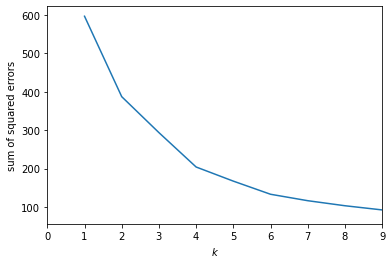

In [3]:
kunden = pd.read_csv('Kundendaten.csv', index_col= 0, delimiter=";", decimal=",")

kunden.rename(columns={'Alter':'Alter', 'Jährliches Einkommen (k€)':'Einkommen', 'Monatsausgaben (Indexwert, 1-100)':'Monatsausgaben'}, inplace = True)

for col in kunden.columns: #iteriert über alle Spalten im Datensatz
    if col == 'Geschlecht':
        continue
    kunden['z_' + col] = (kunden[col]-kunden[col].mean())/kunden[col].std()

X = kunden[['z_Alter', 'z_Einkommen', 'z_Monatsausgaben']].values #Variablen auswählen auf deren Basis klassifiziert werden soll
print(kunden.head())
print(X)

ss = []
krange = list(range(1, 11)) #Hier einstellen, für welches Intervall die sum of squared errors berechnet werden soll
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, ss)
plt.xlabel("$k$")
plt.ylabel("sum of squared errors")
plt.xlim(0,9)
plt.show()  #k=2 oder 3 erscheint sinnvoll